# Microsoft stock price time series

- Data : Microsoft (MSFT) stock price time series ; daily from 2015-01-01 to 2021-01-01
- Problem : forecast daily stock prices for december 2020 using all previous data

## Dataset

- Downloaded from [Yahoo finance](http://finance.yahoo.com)
- For each day from 2015-01-01 to 2021-01-01 : opening, high, low, closing and adjusted closing stock prices
- Will be using daily high prices (column `High`)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_raw = pd.read_table('data/MSFT.csv', sep=',')

In [3]:
data_raw

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,46.660000,47.419998,46.540001,46.759998,41.348206,27913900
1,2015-01-05,46.369999,46.730000,46.250000,46.330002,40.967976,39673900
2,2015-01-06,46.380001,46.750000,45.540001,45.650002,40.366688,36447900
3,2015-01-07,45.980000,46.459999,45.490002,46.230000,40.879539,29114100
4,2015-01-08,46.750000,47.750000,46.720001,47.590000,42.082142,29645200
...,...,...,...,...,...,...,...
1506,2020-12-24,221.419998,223.610001,221.199997,222.750000,221.726166,10550600
1507,2020-12-28,224.449997,226.029999,223.020004,224.960007,223.925995,17933500
1508,2020-12-29,226.309998,227.179993,223.580002,224.149994,223.119720,17403200
1509,2020-12-30,225.229996,225.630005,221.470001,221.679993,220.661072,20272300


In [4]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1511 non-null   object 
 1   Open       1511 non-null   float64
 2   High       1511 non-null   float64
 3   Low        1511 non-null   float64
 4   Close      1511 non-null   float64
 5   Adj Close  1511 non-null   float64
 6   Volume     1511 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 82.8+ KB


In [5]:
data_raw['Date'] = pd.to_datetime(data_raw['Date'])

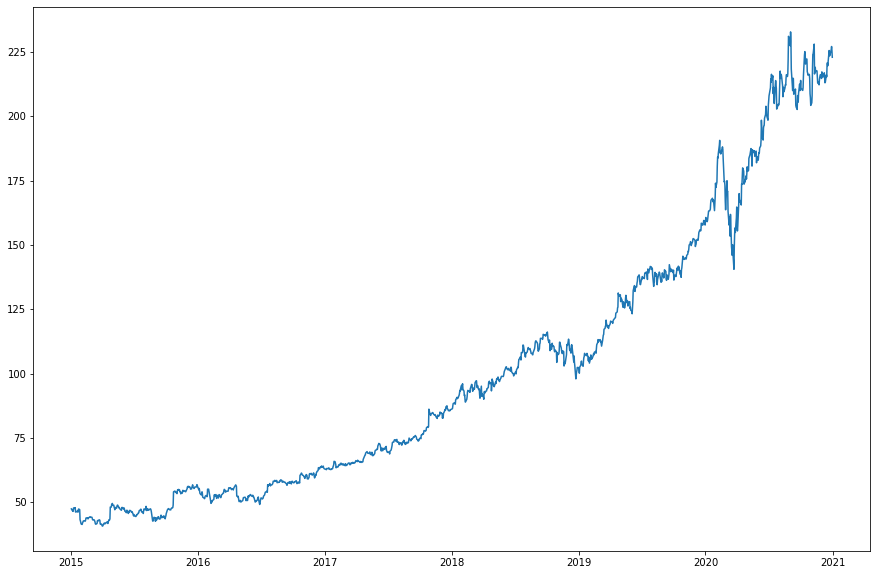

In [6]:
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(data_raw['Date'], data_raw['High'])

## ARIMA

We'll separate the data for december 2020 (which we will plot alongside the forecasts) and use the rest to fit the model.

In [7]:
december_2020 = data_raw[1489:]
data_train = data_raw[:1489]

### Augmented Dickey Fuller Test

In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
result = adfuller(data_train['High'])

In [10]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.663830
p-value: 0.998037


Let's differentiate the series to make it stationary

### Order of differencing, ACF Plot

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

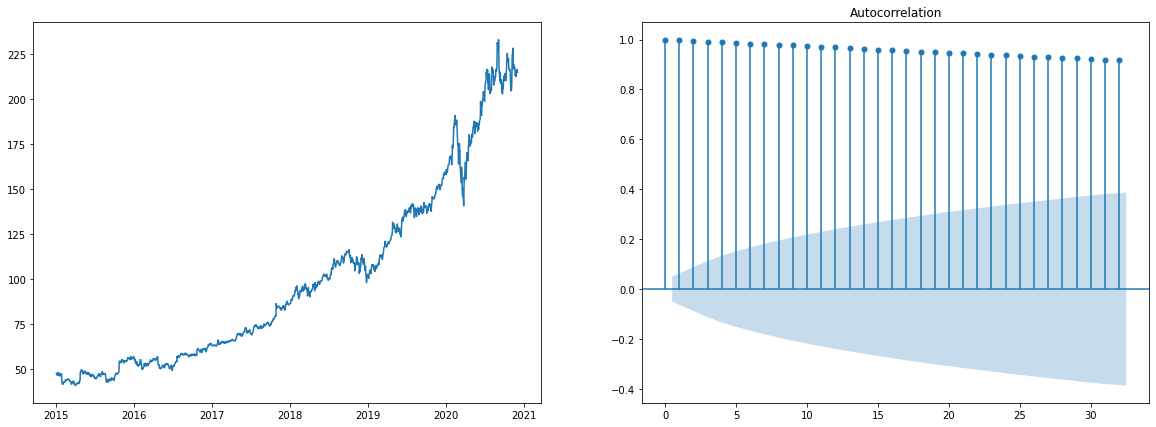

In [12]:
#original series
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.plot(data_train['Date'], data_train['High'])
plot_acf(data_train['High'], ax=ax2);

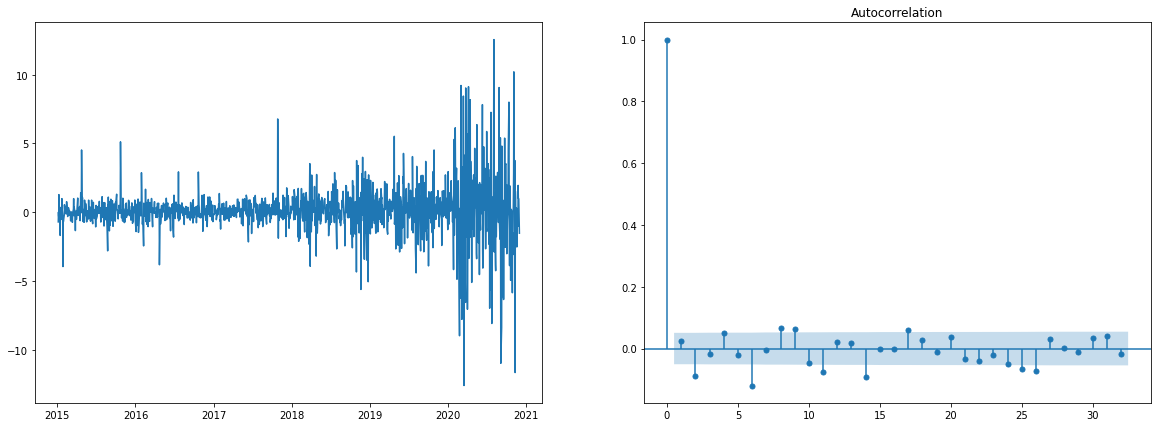

In [13]:
#first order differencing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.plot(data_train['Date'], data_train['High'].diff())
plot_acf(data_train['High'].diff().dropna(), ax=ax2);

In [14]:
result = adfuller(data_train['High'].diff().dropna())
result[1]

3.0338612348635163e-16

First order differencing makes the time series stationary : using `d = 1`

In [15]:
high_diff = data_train['High'].diff().dropna()

### PACF Plot, AR and MA terms

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf

In [17]:
index = list(range(0, len(high_diff)))

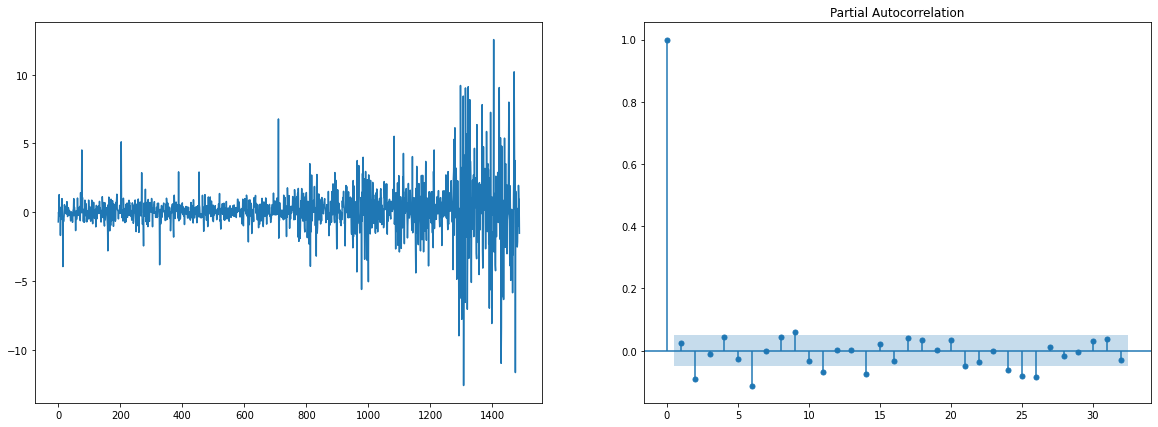

In [18]:
#first order differencing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.plot(index, high_diff)
plot_pacf(high_diff, ax=ax2);

ACF and PACF plots are very similar ; let's try out models with the AR and MA terms in `{1,2}` :

- ARIMA(1,1,1)
- ARIMA(2,1,1)
- ARIMA(1,1,2)
- ARIMA(2,1,2)

We'll choose the best fit using the model summaries (AIC, BIC, p-values of the parameters)

### Choosing the best fit

In [19]:
from statsmodels.tsa.arima.model import ARIMA

**ARIMA(1,1,1)**

In [20]:
model_111 = ARIMA(data_train['High'], order=(1,1,1))
model_111_fit = model_111.fit()
model_111_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                 1489
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2933.566
Date:                Fri, 04 Jun 2021   AIC                           5873.132
Time:                        18:35:27   BIC                           5889.048
Sample:                             0   HQIC                          5879.064
                               - 1489                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9228      0.031    -29.690      0.000      -0.984      -0.862
ma.L1          0.9482      0.026     35.997      0.000       0.897       1.000
sigma2         3.0194      0.043     70.742      0.000       2.936       3.103
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              8999.49
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):              14.68   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**ARIMA(2,1,1)**

In [21]:
model_211 = ARIMA(data_train['High'], order=(2,1,1))
model_211_fit = model_211.fit()
model_211_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                 1489
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2930.716
Date:                Fri, 04 Jun 2021   AIC                           5869.432
Time:                        18:35:27   BIC                           5890.653
Sample:                             0   HQIC                          5877.341
                               - 1489                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0726      0.165      0.441      0.659      -0.250       0.396
ar.L2         -0.0865      0.016     -5.358      0.000      -0.118      -0.055
ma.L1         -0.0414      0.166     -0.249      0.804      -0.367       0.285
sigma2         3.0079      0.042     72.423      0.000       2.927       3.089
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              9691.82
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):              14.78   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**ARIMA(2,1,2)**

In [22]:
model_212 = ARIMA(data_train['High'], order=(2,1,2))
model_212_fit = model_212.fit()
model_212_fit.summary()

/home/vma/Python/venv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/vma/Python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                 1489
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2927.162
Date:                Fri, 04 Jun 2021   AIC                           5864.325
Time:                        18:35:29   BIC                           5890.851
Sample:                             0   HQIC                          5874.211
                               - 1489                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7305      0.007   -101.305      0.000      -0.745      -0.716
ar.L2         -0.9715      0.007   -135.713      0.000      -0.986      -0.957
ma.L1          0.7577      0.006    121.592      0.000       0.745       0.770
ma.L2          0.9865      0.006    171.734      0.000       0.975       0.998
sigma2         3.0062      0.042     71.382      0.000       2.924       3.089
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              9507.44
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              14.80   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**ARIMA(1,1,2)**

In [23]:
model_112 = ARIMA(data_raw['High'], order=(1,1,2))
model_112_fit = model_112.fit()
model_112_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                 1511
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2979.376
Date:                Fri, 04 Jun 2021   AIC                           5966.753
Time:                        18:35:29   BIC                           5988.032
Sample:                             0   HQIC                          5974.678
                               - 1511                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0914      0.170      0.537      0.591      -0.242       0.425
ma.L1         -0.0634      0.171     -0.371      0.711      -0.398       0.271
ma.L2         -0.0818      0.016     -5.218      0.000      -0.113      -0.051
sigma2         3.0292      0.042     72.015      0.000       2.947       3.112
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              9231.12
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):              14.83   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Here we could use either ARIMA(1,1,1) or ARIMA(2,1,2) : going with ARIMA(2,1,2) because AIC is lower

### Residual error plot

In [24]:
residuals = model_212_fit.resid[1:]

(array([0.00053704, 0.00053704, 0.00053704, 0.00107407, 0.00107407,
        0.00322221, 0.00429628, 0.01235181, 0.02255547, 0.09290707,
        0.44735022, 0.14983279, 0.03705542, 0.01020367, 0.00751849,
        0.00214814, 0.00161111, 0.00268518, 0.00107407, 0.00053704]),
 array([-13.16980215, -11.91840715, -10.66701215,  -9.41561714,
         -8.16422214,  -6.91282713,  -5.66143213,  -4.41003713,
         -3.15864212,  -1.90724712,  -0.65585212,   0.59554289,
          1.84693789,   3.0983329 ,   4.3497279 ,   5.6011229 ,
          6.85251791,   8.10391291,   9.35530791,  10.60670292,
         11.85809792]),
 <BarContainer object of 20 artists>)

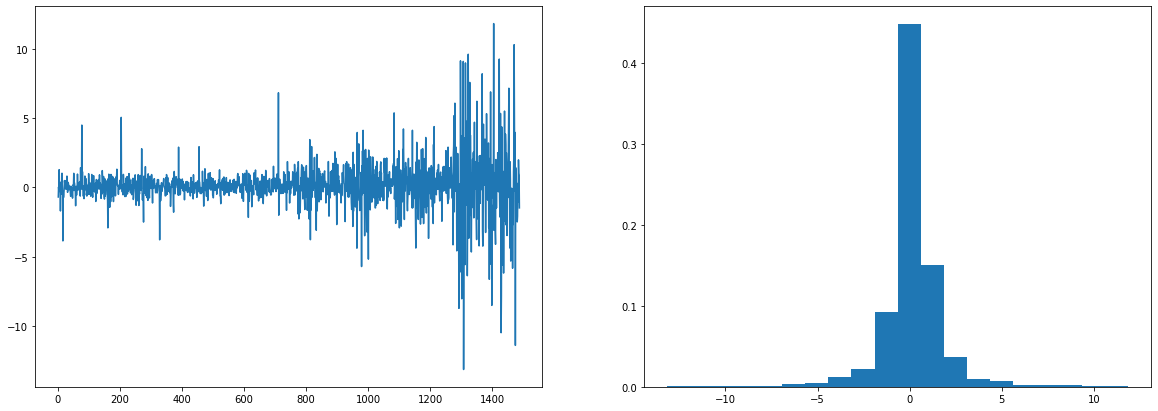

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.plot(residuals)
ax2.hist(residuals, bins=20, density=True)

The fit is not wrong but the model shows limitations in handling the data roughly starting from 2020, ie the covid-19 pandemic. This already shows in the plot of the time series where the behaviour of stock price drastically changes. We could consider studying the data pre- and post-pandemic start separately.

### Forecasting

In [26]:
model_212_forecast = model_212_fit.get_forecast(steps=22).summary_frame(alpha=0.05)
model_212_forecast

High,mean,mean_se,mean_ci_lower,mean_ci_upper
1489,214.671400,1.733841,211.273134,218.069666
1490,214.744939,2.485570,209.873312,219.616566
1491,214.777288,3.052908,208.793698,220.760879
1492,214.682215,3.510458,207.801844,221.562586
1493,214.720238,3.931455,207.014728,222.425748
1494,214.784825,4.316254,206.325123,223.244527
1495,214.700706,4.652687,205.581608,223.819805
1496,214.699409,4.973876,204.950791,224.448026
1497,214.782077,5.284801,204.424057,225.140096
1498,214.722949,5.565480,203.814809,225.631089


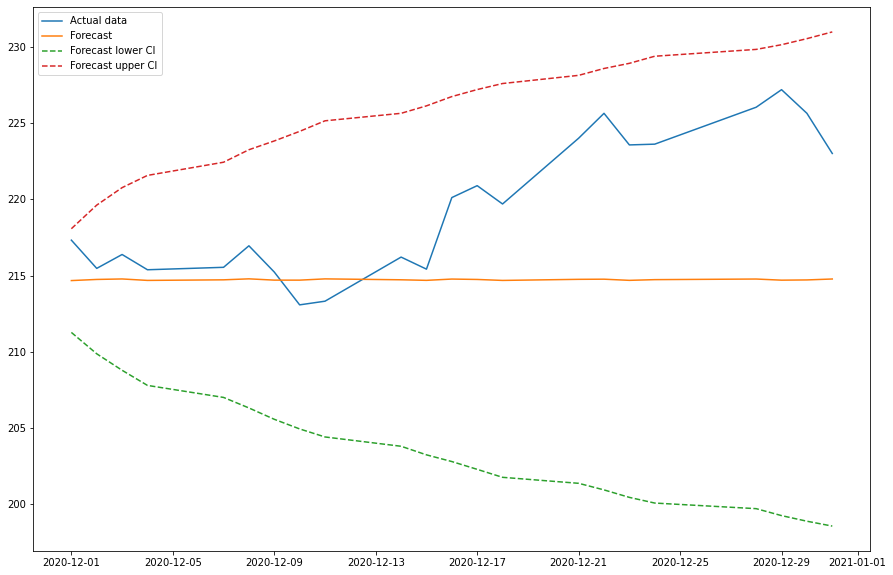

In [27]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(december_2020['Date'], december_2020['High'], label='Actual data')
plt.plot(december_2020['Date'], model_212_forecast['mean'], label='Forecast')
plt.plot(december_2020['Date'], model_212_forecast['mean_ci_lower'], ls='--', label='Forecast lower CI')
plt.plot(december_2020['Date'], model_212_forecast['mean_ci_upper'], ls='--', label='Forecast upper CI')
plt.legend()

## LSTM

Using Keras (Tensorflow)

### Training, validation and testing sets

In [28]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [29]:
data_raw = pd.read_table('data/MSFT.csv', sep=',')

Using the data for december 2020 as a test set, splitting the rest 80% training 20% validation.

In [30]:
data_test = data_raw[1489:]
data_rest = data_raw[:1489]

In [31]:
n = len(data_rest)
data_train = data_rest[:int(n*0.8)]
data_val = data_rest[int(n*0.8):]

In [32]:
data_high = data_raw['High'].to_list()

In [33]:
test_ds = data_high[1489:]
data_high = data_high[:1489]

In [34]:
n = len(data_high)
train_ds = data_high[:int(n*0.8)]
val_ds = data_high[int(n*0.8):]

### Normalization

In [35]:
data_mean = np.mean(train_ds)

In [36]:
data_stdev = np.std(train_ds)

In [37]:
train_ds = train_ds - data_mean
train_ds = train_ds / data_stdev

In [38]:
val_ds = val_ds - data_mean
val_ds = val_ds / data_stdev

### Windowing

Using the `WindowGenerator` class from the [TensorFlow website](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [2]:
data_raw = pd.read_table('data/MSFT.csv', sep=',')
high_raw = data_raw.loc[:, ['High']]

NameError: name 'pd' is not defined

In [3]:
high_test = high_raw[1489:]
high_raw = high_raw[:1489]

n = len(high_raw)
high_train = high_raw[:int(n*0.8)]
high_val = high_raw[int(n*0.8):]

high_mean = np.mean(high_train)
high_std = np.std(high_train)

high_train = (high_train - high_mean) / high_std
high_test = (high_test - high_mean) / high_std
high_val = (high_val - high_mean) / high_std

NameError: name 'high_raw' is not defined

In [69]:
class WindowGenerator():
    def __init__(self,
                 input_width,
                 label_width,
                 shift,
                 train_df,
                 val_df,
                 test_df,
                 label_columns=None):
        #raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        #label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        #window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size : {self.total_window_size}',
            f'Input indices : {self.input_indices}',
            f'Label indices : {self.label_indices}',
            f'Label column name(s) : {self.label_columns}'
        ])

In [42]:
w1 = WindowGenerator(input_width=24,
                     label_width=1,
                     shift=24,
                     train_df=high_train,
                     val_df=high_val,
                     test_df=high_test,
                     label_columns=['High'])

In [43]:
w1

Total window size : 48
Input indices : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices : [47]
Label column name(s) : ['High']

In [44]:
w2 = WindowGenerator(input_width=6,
                    label_width=1,
                    shift=1,
                    train_df = high_train,
                    val_df = high_val,
                    test_df = high_test,
                    label_columns=['High'])

In [45]:
w2

Total window size : 7
Input indices : [0 1 2 3 4 5]
Label indices : [6]
Label column name(s) : ['High']

In [70]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
    
    #set shape manually to make the tf.data.Dataset objetcs easier to inspect
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

WindowGenerator.split_window = split_window

In [47]:
example_window = tf.stack([
    np.array(high_train[:w2.total_window_size]),
    np.array(high_train[100:100+w2.total_window_size]),
    np.array(high_train[200:200+w2.total_window_size])
])

In [48]:
example_inputs, example_labels = w2.split_window(example_window)

In [49]:
print('All shapes are : (batch, time, features)')
print(f'Window shape : {example_window.shape}')
print(f'Inputs shape : {example_inputs.shape}')
print(f'Labels shape : {example_labels.shape}')

All shapes are : (batch, time, features)
Window shape : (3, 7, 1)
Inputs shape : (3, 6, 1)
Labels shape : (3, 1, 1)


In [50]:
w2.example = example_inputs, example_labels

In [112]:
def plot(self, model, plot_col, max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12,8))
    plot_col_index = self.column_indices[plot_col]
    
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
            
        if label_col_index is None:
            continue
        
        plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)
        
        if n == 0:
            plt.legend()
    
    plt.xlabel('Time')

In [118]:
WindowGenerator.plot = plot

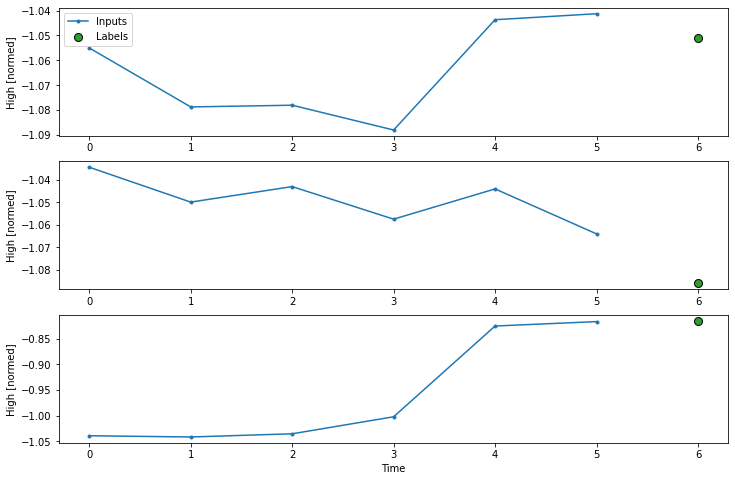

In [53]:
w2.plot(model=None, plot_col='High')

In [72]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )
    
    ds = ds.map(self.split_window)
    return ds

In [73]:
WindowGenerator.make_dataset = make_dataset

In [74]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of inputs, labels for plotting"""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the train dataset
        result = next(iter(self.train))
        # Cache it
        self._example = result
    
    return result

In [75]:
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [58]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [59]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [60]:
single_step_window = WindowGenerator(
    input_width=1,
    label_width=1,
    shift=1,
    train_df=high_train,
    val_df=high_val,
    test_df=high_test,
    label_columns=['High']
)

In [61]:
single_step_window

Total window size : 2
Input indices : [0]
Label indices : [1]
Label column name(s) : ['High']

In [62]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [63]:
class BaseLine(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [ ]:
wide_window = WindowGenerator(
    input_width=10,
    label_width=10,
    shift=1,
    train_df=high_train,
    val_df=high_val,
    test_df=high_test,
    label_columns=['High']
)

In [64]:
wide_window.column_indices['High']

NameError: name 'wide_window' is not defined

In [ ]:
baseline = BaseLine(label_index=wide_window.column_indices['High'])

In [ ]:
baseline.compile(
    loss = tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

In [ ]:
val_performance = {}
performance = {}

In [ ]:
val_performance = {}
performance = {}

val_performance['BaseLine'] = baseline.evaluate(single_step_window.val)

In [ ]:
performance['Baseline'] = baseline.evaluate(single_step_window.test)

In [ ]:
wide_window = WindowGenerator(
    input_width=10,
    label_width=10,
    shift=1,
    train_df=high_train,
    val_df=high_val,
    test_df=high_test,
    label_columns=['High']
)

In [ ]:
wide_window

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

In [ ]:
wide_window.plot(baseline, plot_col='High')

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

In [76]:
MAX_EPOCHS = 20

In [77]:
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(),
                 optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=MAX_EPOCHS,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [ ]:
history = compile_and_fit(linear, single_step_window)

In [ ]:
single_step_window

In [ ]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test)

In [ ]:
wide_window

In [ ]:
wide_window.plot(linear, plot_col='High')

In [ ]:
plt.bar(
    x=range(len(high_train.columns)),
    height=linear.layers[0].kernel[:,0].numpy()
)

axis = plt.gca()
axis.set_xticks(range(len(high_train.columns)))
_ = axis.set_xticklabels(high_train.columns, rotation=90)

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(dense, single_step_window)

In [ ]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [ ]:
wide_window.plot(dense, plot_col='High')

In [ ]:
history = compile_and_fit(dense, single_step_window)

In [ ]:
wide_window.plot(dense, plot_col='High')

In [ ]:
history = compile_and_fit(dense, wide_window)

In [ ]:
CONV_WIDTH = 3

In [ ]:
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    train_df=high_train,
    val_df=high_val,
    test_df=high_test,
    label_columns=['High']
)

In [ ]:
conv_window

In [ ]:
conv_window.plot(model=None, plot_col='High')

In [ ]:
multi_step_dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

In [ ]:
conv_window.plot(multi_step_dense, plot_col='High')

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=(CONV_WIDTH,), activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(conv_model, conv_window)

In [ ]:
conv_window.plot(conv_model, plot_col='High')

In [ ]:
window = WindowGenerator(
    input_width=20,
    label_width=20,
    shift=20,
    train_df=high_train,
    val_df=high_val,
    test_df=high_test,
    label_columns=['High']
)

In [ ]:
window

In [ ]:
dense_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(dense_model, window)

In [ ]:
window.plot(dense_model, plot_col='High')

In [ ]:
dense_model.summary()

In [ ]:
window

In [ ]:
inputs, labels = window.example

In [ ]:
labels.shape

In [ ]:
inputs.shape

In [ ]:
len(inputs)

In [ ]:
len(high_test)

In [ ]:
high_test

In [ ]:
high_val[-20:]

In [ ]:
high_test

=
=
=
=
=
=
=
=
=
=


In [100]:
data_raw = pd.read_table('data/MSFT.csv', sep=',')
high_raw = data_raw.loc[:, ['High']]

In [101]:
high_test = high_raw[1489:]
high_raw = high_raw[:1489]

n = len(high_raw)
high_train = high_raw[:int(n*0.8)]
high_val = high_raw[int(n*0.8):]

high_mean = np.mean(high_train)
high_std = np.std(high_train)

high_train = (high_train - high_mean) / high_std
high_test = (high_test - high_mean) / high_std
high_val = (high_val - high_mean) / high_std

In [102]:
high_std

High    28.991413
dtype: float64

In [103]:
print(len(high_train))
print(len(high_test))
print(len(high_val))

1191
22
298


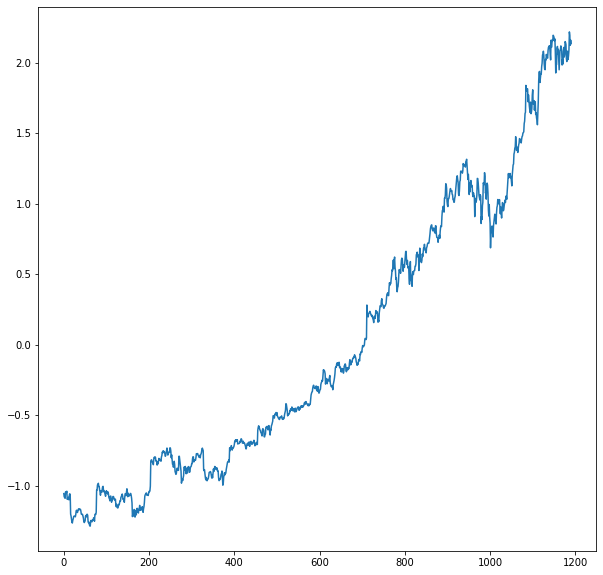

In [104]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(high_train)

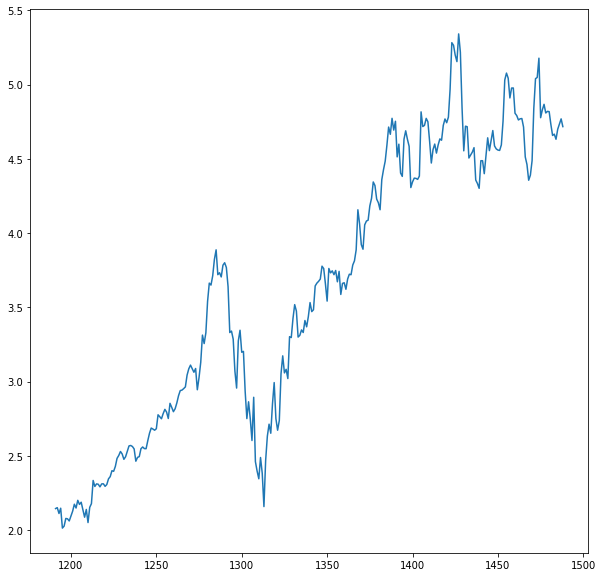

In [105]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(high_val)

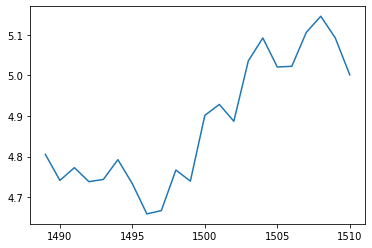

In [106]:
plt.plot(high_test)

In [107]:
window = WindowGenerator(
    input_width=20,
    label_width=20,
    shift=20,
    train_df=high_train,
    val_df=high_val,
    test_df=high_test,
    label_columns=['High']
)

In [114]:
window

Total window size : 40
Input indices : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices : [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Label column name(s) : ['High']

In [115]:
dense_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [116]:
history = compile_and_fit(dense_model, window)

Epoch 1/20
36/36 [==============================] - 1s 7ms/step - loss: 0.5973 - mean_absolute_error: 0.5772 - val_loss: 8.6792 - val_mean_absolute_error: 2.8597
Epoch 2/20
36/36 [==============================] - 0s 4ms/step - loss: 0.1706 - mean_absolute_error: 0.2639 - val_loss: 2.5346 - val_mean_absolute_error: 1.5077
Epoch 3/20
36/36 [==============================] - 0s 4ms/step - loss: 0.0406 - mean_absolute_error: 0.1442 - val_loss: 0.7055 - val_mean_absolute_error: 0.7698
Epoch 4/20
36/36 [==============================] - 0s 5ms/step - loss: 0.0318 - mean_absolute_error: 0.1329 - val_loss: 0.7742 - val_mean_absolute_error: 0.8112
Epoch 5/20
36/36 [==============================] - 0s 5ms/step - loss: 0.0290 - mean_absolute_error: 0.1257 - val_loss: 0.5730 - val_mean_absolute_error: 0.6873
Epoch 6/20
36/36 [==============================] - 0s 5ms/step - loss: 0.0256 - mean_absolute_error: 0.1189 - val_loss: 0.4169 - val_mean_absolute_error: 0.5737
Epoch 7/20
36/36 [==========

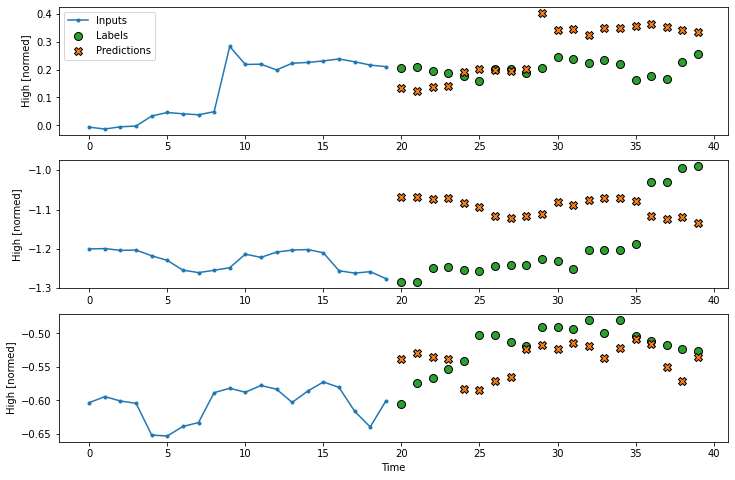

In [119]:
window.plot(dense_model, plot_col='High')

In [120]:
high_val[-20:];

In [121]:
np.array(high_test[:20])

array([[4.80531147],
       [4.74149926],
       [4.772888  ],
       [4.73839503],
       [4.74391349],
       [4.79254872],
       [4.73322078],
       [4.65906109],
       [4.66733958],
       [4.76702427],
       [4.73977451],
       [4.90154665],
       [4.9284511 ],
       [4.88705964],
       [5.03572428],
       [5.091948  ],
       [5.0205473 ],
       [5.02227205],
       [5.10574498],
       [5.14541169]])

In [122]:
sim_0 = dense_model(np.array(high_val[-20:]))

In [123]:
sim_0.shape

TensorShape([20, 1, 1])

In [124]:
sim_0_b = tf.reshape(sim_0, shape=[20])

In [125]:
sim_0_b

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([4.0204015, 4.1042147, 4.405234 , 4.5764003, 4.5834837, 4.6944466,
       4.351522 , 4.3969693, 4.4285474, 4.3786726, 4.388117 , 4.386346 ,
       4.312271 , 4.249117 , 4.256789 , 4.2272778, 4.2851205, 4.3158126,
       4.344734 , 4.300172 ], dtype=float32)>

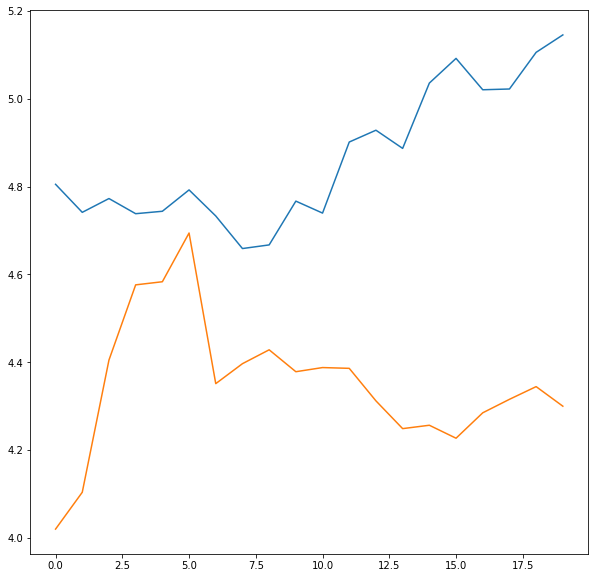

In [126]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(list(range(0, 20)), high_test['High'][:20], label='Real data')
plt.plot(list(range(0, 20)), sim_0_b, label='Simulation')

In [359]:
window_2 = WindowGenerator(
    input_width=3,
    label_width=3,
    shift=3,
    train_df=high_train,
    val_df=high_val,
    test_df=high_test,
    label_columns=['High']
)

In [360]:
window_2

Total window size : 6
Input indices : [0 1 2]
Label indices : [3 4 5]
Label column name(s) : ['High']

In [361]:
dense_model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [362]:
history_2 = compile_and_fit(dense_model_2, window_2)

Epoch 1/20
38/38 [==============================] - 1s 11ms/step - loss: 0.6955 - mean_absolute_error: 0.6211 - val_loss: 5.7939 - val_mean_absolute_error: 2.3154
Epoch 2/20
38/38 [==============================] - 0s 4ms/step - loss: 0.0754 - mean_absolute_error: 0.1744 - val_loss: 0.3629 - val_mean_absolute_error: 0.5342
Epoch 3/20
38/38 [==============================] - 0s 4ms/step - loss: 0.0255 - mean_absolute_error: 0.1178 - val_loss: 0.4039 - val_mean_absolute_error: 0.5728
Epoch 4/20
38/38 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.1055 - val_loss: 0.2856 - val_mean_absolute_error: 0.4738
Epoch 5/20
38/38 [==============================] - 0s 4ms/step - loss: 0.0183 - mean_absolute_error: 0.0985 - val_loss: 0.2177 - val_mean_absolute_error: 0.4090
Epoch 6/20
38/38 [==============================] - 0s 4ms/step - loss: 0.0160 - mean_absolute_error: 0.0896 - val_loss: 0.1294 - val_mean_absolute_error: 0.3032
Epoch 7/20
38/38 [=========

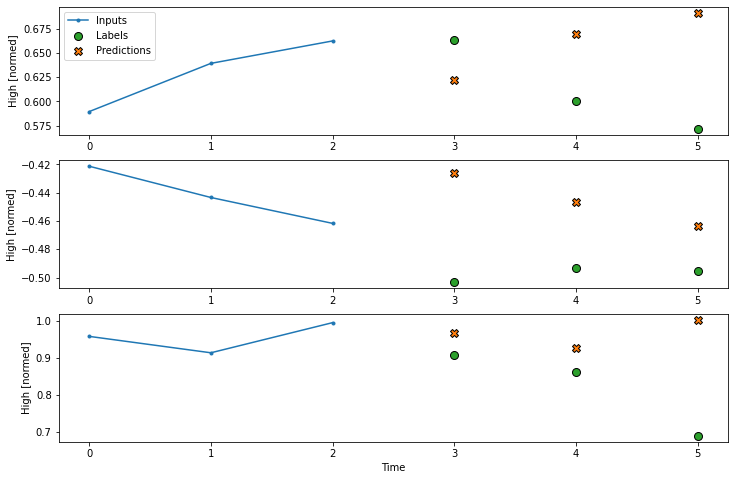

In [363]:
window_2.plot(dense_model_2, plot_col='High')

In [364]:
walk = []

In [365]:
step = dense_model_2(np.array(high_val[-1:]))
walk.append(step.numpy()[0][0][0])

In [366]:
for i in range(19):
    step = dense_model_2(step)
    walk.append(step.numpy()[0][0][0])

In [367]:
walk

[4.4947724,
 4.2866445,
 4.0917287,
 3.9091876,
 3.7382345,
 3.5781343,
 3.4281979,
 3.2877793,
 3.1562755,
 3.0331204,
 2.917783,
 2.8097682,
 2.7086103,
 2.613874,
 2.525152,
 2.4420626,
 2.3642476,
 2.2913728,
 2.2230177,
 2.1588283]